In [1]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
import os
from pathlib import Path


In [2]:
from src.model.modelImprovisedGan import Encoder,Decoder,Critic
from src.utils.losses import Wasserstein
from src.utils.util import *
from src.dataset.Nabdataset import NabDataset
from src.algorithms.ImprovisedGAN import ImprovisedGAN

/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    


23:33:54


<h4>Initializing Dataset</h4>

In [36]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)



class Datasettings:
    
    def __init__(self):
        end_name='exchange-2_cpc_results.csv'
        self.data_folder_path = Path.cwd().joinpath("data", "nab")
        key='realAdExchange/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=True
        self.window_length=60

In [37]:
data_settings = Datasettings()
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature
n_features=dataset.x.shape[2]
sequences=[x for i, (x,y) in enumerate(dataloader, 0)]

data_folder_path /Users/ss049a/gitWorkspace/ImprovisedGAN/data/nab


/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, 

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [34]:
dataset.x.shape

torch.Size([17303, 60, 1])

In [8]:
'''
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
'''

'\nimport torch\nimport sys\nprint(\'__Python VERSION:\', sys.version)\nprint(\'__pyTorch VERSION:\', torch.__version__)\nprint(\'__CUDA VERSION\')\nfrom subprocess import call\n# call(["nvcc", "--version"]) does not work\n! nvcc --version\nprint(\'__CUDNN VERSION:\', torch.backends.cudnn.version())\nprint(\'__Number CUDA Devices:\', torch.cuda.device_count())\nprint(\'__Devices\')\ncall(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])\nprint(\'Active CUDA Device: GPU\', torch.cuda.current_device())\nprint (\'Available devices \', torch.cuda.device_count())\nprint (\'Current cuda device \', torch.cuda.current_device())\n'

In [35]:
improvisedGAN=ImprovisedGAN(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,in_dim=in_dim)

<h4>CriticX training</h4>

In [10]:
criticX=improvisedGAN.train_criticX(sequences)

/Users/ss049a/gitWorkspace/ImprovisedGAN/src/algorithms/ImprovisedGAN.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss -0.5645150644735686
Epoch 1: train loss -0.1021029700578471
Epoch 2: train loss 0.002376608949932726
Epoch 3: train loss -0.007583002396299747
Epoch 4: train loss -0.010867427644111532


In [11]:
PATH = Path.cwd().joinpath("src","saved_models","improvisedgan","nab", "criticX.pkl")


In [12]:
torch.save(criticX.module.state_dict(), PATH)

In [13]:
criticX=Critic(in_dim=in_dim,device=device)
criticX=nn.DataParallel(criticX)
criticX.to(device)
state_dict = torch.load(PATH)
criticX=improvisedGAN.load_model(state_dict,criticX)

<h4>CriticZ training</h4>

In [14]:
criticZ=improvisedGAN.train_criticZ(sequences)

/Users/ss049a/gitWorkspace/ImprovisedGAN/src/algorithms/ImprovisedGAN.py:141: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss -0.801319845948995
Epoch 1: train loss -0.007405769353983803
Epoch 2: train loss -0.03040169961681648
Epoch 3: train loss -1.6518096591760845
Epoch 4: train loss -1.2628028450137807


In [15]:
PATH = Path.cwd().joinpath("src","saved_models","improvisedgan","nab", "criticZ.pkl")


In [16]:
torch.save(criticZ.module.state_dict(), PATH)

In [17]:
criticZ=Critic(in_dim=in_dim,device=device)
criticZ=nn.DataParallel(criticZ)
criticZ.to(device)
state_dict = torch.load(PATH)
criticZ=improvisedGAN.load_model(state_dict,criticZ)

<h4>Encoder and Decoder training</h4>

In [18]:
encoder,decoder=improvisedGAN.train_enc_dec(sequences)

/Users/ss049a/gitWorkspace/ImprovisedGAN/src/algorithms/ImprovisedGAN.py:173: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss 0.8531242915861267
Epoch 1: train loss 0.08540162614885849
Epoch 2: train loss 0.030826344672941677
Epoch 3: train loss -0.017223625053099035
Epoch 4: train loss -0.041819861823221234


In [19]:
PATH_encoder = Path.cwd().joinpath("src","saved_models","improvisedgan","nab", "encoder.pkl")

PATH_decoder = Path.cwd().joinpath("src","saved_models","improvisedgan","nab", "decoder.pkl")

In [20]:
torch.save(encoder.module.state_dict(), PATH_encoder)
torch.save(decoder.module.state_dict(), PATH_decoder)

In [21]:
encoder=Encoder(n_features=in_dim, embedding_dim=in_dim,device=device)
encoder=nn.DataParallel(encoder)
encoder.to(device)
state_dict = torch.load(PATH_encoder)
encoder=improvisedGAN.load_model(state_dict,encoder)

In [22]:
decoder=Decoder(in_dim=in_dim,out_dim=in_dim,device=device)
decoder=nn.DataParallel(decoder)
decoder.to(device)
state_dict = torch.load(PATH_decoder)
decoder=improvisedGAN.load_model(state_dict,decoder)

<h4>Loading back saved models</h4>

In [23]:
improvisedGAN.initialize_models(criticX,criticZ,decoder,encoder)

<h2>Testing for anomaly</h2>

In [24]:

class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()

class TestDataSettings:
    
    def __init__(self):
        end_name='exchange-2_cpc_results.csv'
        self.data_folder_path = Path.cwd().joinpath("data", "nab")
        key='realAdExchange/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=False
        self.window_length=60       
        
test_data_settings = TestDataSettings()

In [25]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape
test_sequences=[x for i, (x,y) in enumerate(test_dataloader, 0)]

data_folder_path /Users/ss049a/gitWorkspace/ImprovisedGAN/data/nab


/Users/ss049a/gitWorkspace/ImprovisedGAN/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [26]:
losses=improvisedGAN.predict_loss(test_sequences)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

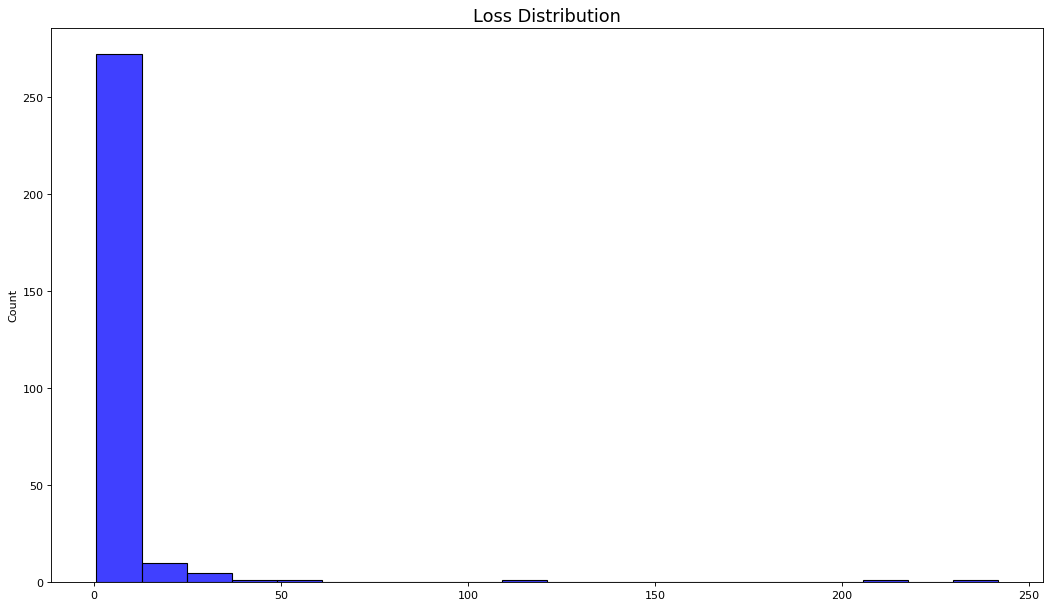

In [28]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

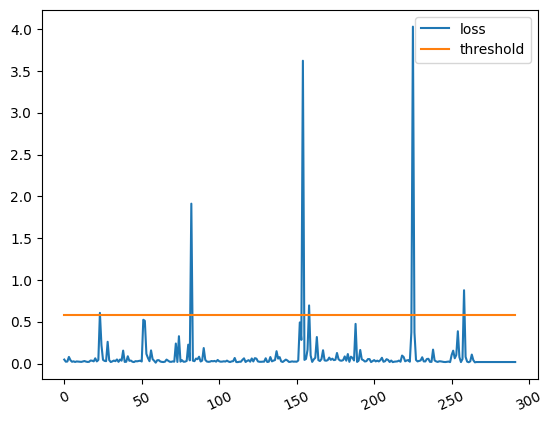

In [29]:
THRESHOLD =0.58

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss/60 for loss in losses]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();


In [30]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [31]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 0
True Negative	 283
False Positive	 6
False Negative	 3


ZeroDivisionError: float division by zero